In [12]:
from os.path import join
import pandas as pd
from glob import glob
import re
import matplotlib.pyplot as plt
import numpy as np

zip_pattern = re.compile('\d{5}')
def format_zip(z):
    matches = zip_pattern.findall(z)
    if len(matches) >= 1:
        return int(matches[0])
    else:
        return -1
    
def load(filepath='./chicago/clean.hdf'):
    """ Load preprocessed license data from <filepath>. """
    df = pd.read_hdf(filepath, 'licenses')
    return df

def save(df, filepath='./chicago/clean.hdf'):
    """ Save license data to <filepath>. """
    df.to_hdf(filepath, 'licenses', mode='w')

%matplotlib inline

In [9]:
import quandl
import geopandas as gpd

class ZillowAPI:
    
    def __init__(self, API_KEY):
        self.API_KEY = API_KEY
        quandl.ApiConfig.api_key = API_KEY
    
    def query(self, zipcode, indicator):
        """ Query Quandl portal to Zillow API for <area> and <indicator>. """
        return quandl.get('ZILLOW/Z{:d}_{:s}'.format(zipcode, indicator), returns="pandas")
    
    def query_MVALFAH(self, zipcode):
        """ Query median value per square foot for all houses in <zipcode>. """
        return self.query(zipcode, 'MVALFAH')
    

        

In [2]:
DATEVARS = [
    'APPLICATION CREATED DATE',
    'APPLICATION REQUIREMENTS COMPLETE',
    'PAYMENT DATE',
    'LICENSE TERM START DATE',
    'LICENSE TERM EXPIRATION DATE',
    'LICENSE APPROVED FOR ISSUANCE',
    'DATE ISSUED',
    'LICENSE STATUS CHANGE DATE']

dtypes = {
    'ID': str, 
    'LICENSE ID': int, 
    'ACCOUNT NUMBER': int, 
    'SITE NUMBER': int, 
    'LEGAL NAME': str,
    'DOING BUSINESS AS NAME': str, 
    'ADDRESS': str, 
    'CITY': str, 
    'STATE': str, 
    'ZIP CODE': str,
    'WARD': float, 
    'PRECINCT': float, 
    'WARD PRECINCT': str, 
    'POLICE DISTRICT': str, 
    'LICENSE CODE': int,
    'LICENSE DESCRIPTION': str, 
    'BUSINESS ACTIVITY ID': str, 
    'BUSINESS ACTIVITY': str,
    'LICENSE NUMBER': float, 
    'APPLICATION TYPE': str, 
    'APPLICATION CREATED DATE': str,
    'APPLICATION REQUIREMENTS COMPLETE': str, 
    'PAYMENT DATE': str,
    'CONDITIONAL APPROVAL': str, 
    'LICENSE TERM START DATE': str,
    'LICENSE TERM EXPIRATION DATE': str, 
    'LICENSE APPROVED FOR ISSUANCE': str,
    'DATE ISSUED': str, 
    'LICENSE STATUS': str, 
    'LICENSE STATUS CHANGE DATE': str, 
    'SSA': float,
    'LATITUDE': float, 
    'LONGITUDE': float, 
    'LOCATION': str
}

In [5]:
"""
LOAD AND PREPROCESS DATA.
"""

# gather detail CSV filepaths
filepath = glob(join('./chicago', '*.csv'))[0]

# read data from each CSV file
with open(filepath, 'r', encoding='utf-8') as file:
    df = pd.read_csv(file, dtype=dtypes)
    
# limit to IL and zip codes beginning with '6'
df = df[df['STATE']=='IL']
df = df[df['ZIP CODE'].apply(lambda x: str(x)[0]=='6')]

# exclude values with zip codes
df = df[~df['ZIP CODE'].isna()]
df.loc[:, 'ZIP CODE'] = df['ZIP CODE'].apply(format_zip)

# format datestrings
format_datestr = lambda x: pd.datetime.strptime(x, '%m/%d/%Y') if type(x) == str else None
for DATEVAR in DATEVARS:
    df.loc[:, DATEVAR] = df[DATEVAR].apply(format_datestr)

# sort by application date
df = df.sort_values(by='DATE ISSUED')

# determine number of locations per account
accounts = df.groupby('ACCOUNT NUMBER')
num_locations = accounts['SITE NUMBER'].apply(lambda x: x.unique().size)

save(df)

In [148]:
"""
QUERY HOUSE PRICE DATA FROM QUANDL ZILLOW API
"""

import quandl

# define unique zipcodes
zipcodes = df['ZIP CODE'].unique()

# query housing prices from zillow API and write to hdf5
zillow = ZillowAPI("DQS8Touz-5JVz9pdSxhf")
failed = []

with pd.HDFStore(path='./chicago/houseprices.hdf', mode='a') as hdf:
    
    for i, zipcode in enumerate(zipcodes):
        try:
            houseprices = zillow.query_MVALFAH(zipcode)
            
            # skip entries with zero values
            if (houseprices.values == 0).sum() > 0:
                failed.append(zipcode)
                continue
            
            # add zipcode to key
            houseprices.rename({'Value': zipcode}, axis=1, inplace=True)
            
            # store as hdf5
            hdf.put('Z{:d}'.format(zipcode), houseprices, format='fixed')            

        except:
            failed.append(zipcode)
                
        if i % 25 == 0:
            print('{:0.2%} complete'.format(i/zipcodes.size))

0.00% complete
6.14% complete
12.29% complete
18.43% complete
24.57% complete
30.71% complete
36.86% complete
43.00% complete
49.14% complete
55.28% complete
61.43% complete
67.57% complete
73.71% complete
86.00% complete
92.14% complete


In [38]:
class HousingData:
    
    def __init__(self, path='./chicago/houseprices.hdf'):
        self.path = path
        
        # load keys
        with pd.HDFStore(path=self.path, mode='r') as hdf:
            keys = hdf.keys()
        self.zipcodes = np.array([int(k.lstrip('/Z')) for k in keys if k[1]=='Z'], dtype=int)
        
    def __getitem__(self, zipcode):
        return self.load(zipcode)
    
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n < self.num_zipcodes:
            timeseries = self.load(self.zipcodes[self.n])            
            self.n += 1
            return timeseries
        else:
            raise StopIteration
            
    @property
    def num_zipcodes(self):
        return len(self.zipcodes)
    
    @property
    def missing(self):
        """ Zipcodes for which data were unavailable. """
        with pd.HDFStore(path=self.path, mode='r') as hdf:
            failures = hdf.get('failed')
        return failures
            
    def load(self, zipcode):
        """ Load market timeseries for <zipcode> from file. """
        with pd.HDFStore(path=self.path, mode='r') as hdf:
            timeseries = hdf.get('Z{:d}'.format(zipcode))
        return timeseries        

In [26]:
# load chicago city geography 
chimap = ChicagoMap()

In [39]:
# load housing data
realestate = HousingData()

In [28]:
# load preprocessed licensitng data
licensing = load()

In [29]:
from functools import reduce

# TEMPORARY: limit analysis to zipcodes available in all three datasets
keys = (chimap.zipcodes, realestate.zipcodes, licensing['ZIP CODE'].unique())
common_zipcodes = reduce(lambda x,y: np.intersect1d(x,y), keys)
licensing = licensing[licensing['ZIP CODE'].isin(common_zipcodes)]
price_matrix = pd.concat(realestate, axis=1).loc[:, common_zipcodes].resample('3M').mean()

In [977]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.pyplot import colorbar
from matplotlib.dates import YearLocator, DateFormatter
from matplotlib.animation import FuncAnimation

class ChicagoMap:

    def __init__(self, 
                 timeseries,
                 dirpath='./chicago/', 
                 cbar=True, 
                 timeline=True,
                 figsize=(4, 4),
                 cmap=None, 
                 vmin=-1, 
                 vmax=1, 
                 label=None,
                 bg='w',
                 **kwargs):
        
        # load geomap
        self.citylimits = gpd.read_file(join(dirpath, 'chicago.geojson'))
        self.ziplimits = gpd.read_file(join(dirpath, 'chicago_zips.geojson'))
        self.ziplimits.zip = self.ziplimits.zip.astype(int)
        
        # add timeseries (smoothed)
        self.timeseries = timeseries.resample('1M', axis=0).interpolate().transpose()
        
        # set colormap
        if cmap is None:
            cmap = plt.cm.Blues
        cmap.set_bad(bg)
        self.cmap = cmap    
        self.norm = Normalize(vmin=vmin, vmax=vmax)
        
        # create figure and plot city limits
        self.create_figure(figsize=figsize, cbar=cbar, timeline=True)
        self.initialize_city_limits(**kwargs)
        self.initialize_zip_codes(**kwargs)
        
        # add colorbar
        if cbar:
            self.draw_colorbar(cmap, vmin, vmax, label=label)
            
        # add timeline
        if timeline:
            self.draw_timeline()

    @property
    def zipcodes(self):
        """ Unique zipcodes. """
        return self.ziplimits.zip.unique().astype(int)

    @property
    def num_frames(self):
        return self.timeseries.shape[1]
    
    @property
    def ax(self):
        return self.fig.axes[0]
    
    @property
    def cax(self):
        return self.fig.axes[self.cax_ind]
    
    @property
    def tax(self):
        return self.fig.axes[self.tax_ind]
    
    def create_figure(self, figsize=(4, 4), cbar=True, timeline=True):
        """ Create figure. """
        self.fig = plt.figure(figsize=figsize)
        
        gs = GridSpec(nrows=3, ncols=3, height_ratios=(1,25,3), width_ratios=[1,2,1])
        gs.update(wspace=0., hspace=0)
        
        # add map axis
        self.fig.add_subplot(gs[1:-1, :])
        
        if cbar:
            self.cax_ind = len(self.fig.axes)
            self.fig.add_subplot(gs[0, 1])
                    
        if timeline:
            self.tax_ind = len(self.fig.axes)
            self.fig.add_subplot(gs[-1, :])
        
        # turn off axes
        self.ax.axis('off')
        self.ax.set_aspect(1)
    
    def draw_timeline(self):
        self.tax.set_yticks([])
        self.tax.spines['top'].set_visible(False)
        self.tax.spines['left'].set_visible(False)
        self.tax.spines['right'].set_visible(False)

        start = self.timeseries.columns.min()
        stop = self.timeseries.columns.max()
        self.tax.plot((start, stop), (0,0), alpha=0)

        self.tax.get_xaxis().set_major_locator(YearLocator(1, month=3))
        self.tax.get_xaxis().set_major_formatter(DateFormatter("%Y"))
        self.tax.xaxis.set_tick_params(rotation=45)
        self.tax.tick_params(pad=0, length=0)
        self.tax.set_ylim(0, 1)
        
    def draw_colorbar(self, cmap, vmin, vmax, label=None):
        norm = Normalize(vmin=vmin, vmax=vmax)
        cbar = ColorbarBase(self.cax, cmap=cmap, norm=norm, orientation='horizontal')
        cbar.set_ticks([])
        cbar.set_label(label)
        cbar.ax.xaxis.set_label_position('top')
                    
    def initialize_city_limits(self, color='w', edgecolor='k', lw=.5, **kwargs):
        """ Add city limits to axes. """
        self.citylimits.plot(ax=self.ax, color=color, edgecolor=edgecolor, lw=lw, **kwargs)
        
    def initialize_zip_codes(self, **kwargs):
        """ Add zipcodes to axes. """
        
        # build shader
        shader = self.build_shader(0)
        
        # shade zipcode polygons    
        shader.plot(column='VALUE', cmap=plt.cm.Greys, vmin=0, vmax=0, ax=self.ax, **kwargs)
        self.shade(0)
        
        # set date marker
        #self.tax.scatter(self.timeseries.columns[0], .5, s=50, c='k') 
        self.tax.plot(self.timeseries.columns[0], .5, '.k', markersize=10) 
        
    def build_shader(self, index):
        
        # get color vector
        colors = self.timeseries.iloc[:, index].rename('VALUE')
        
        # join with zipdata
        shader = self.ziplimits.join(colors, on='zip', how='left')
        
        return shader
    
    def shade(self, index):
        
        # build shader
        shader = self.build_shader(index)
        
        # shade zipcodes
        colors = self.cmap(np.ma.masked_invalid(self.norm(shader.VALUE.values)))        
        self.ax.collections[-1].set_facecolors(colors)
        
    def set_title(self, index):
        date = self.timeseries.columns[index].strftime('%b-%Y')
        self.ax.set_title(date)
                
    def update(self, index):
        self.shade(index)
        self.mark_time(index)
        
    def mark_time(self, index):
        date = self.timeseries.columns[index]
        self.tax.lines[0].set_data(date, 0.5)
        
    def fix_date(self, date):
        index = self.timeseries.columns.get_loc(date).start
        self.update(index)
        
    def animate(self, filepath, fps=12, dpi=150):
        vid = FuncAnimation(self.fig, self.update, frames=np.arange(self.num_frames))
        vid.save(filepath, fps=fps, dpi=dpi)

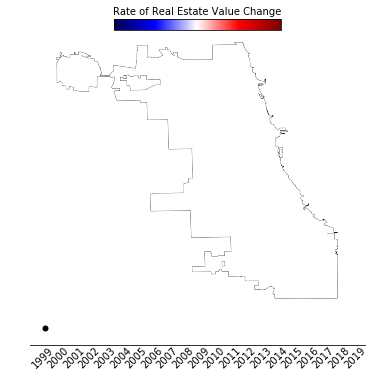

In [978]:
chimap = ChicagoMap(timeseries=derivative, 
                    cbar=True, figsize=(6, 6), 
                    vmin=-0.2, vmax=0.2, 
                    cmap=plt.cm.seismic, label='Rate of Real Estate Value Change')

In [979]:
# save animated price derivative map
chimap.animate('./chicago/derivates.mp4')

In [982]:
%%HTML
<video width="640" height="480" controls>
  <source src="./chicago/derivates.mp4" type="video/mp4">
</video>

# Licensing Data

In [985]:
import numpy as np

# identify newly issued licenses
new = licensing[np.logical_and(licensing['APPLICATION TYPE']=='ISSUE', licensing['LICENSE STATUS'] == 'AAI')]
renewed = licensing[np.logical_and(licensing['APPLICATION TYPE']!='ISSUE', licensing['LICENSE STATUS'] == 'AAI')]
failed = licensing[licensing['LICENSE STATUS'] != 'AAI']

In [988]:
# TO DO: expired and not renewed licenses?
criteria = ['DATE ISSUED', 'ZIP CODE', 'LICENSE CODE']
additions = new.groupby(criteria).size().groupby(level=[0, 1]).sum().unstack(level=1).resample('3M', axis=0).sum()
renewals = renewed.groupby(criteria).size().groupby(level=[0, 1]).sum().unstack(level=1).resample('3M', axis=0).sum()

In [1058]:
freq = '3Y'
annual_additions = additions.resample(freq, axis=0).sum()
annual_renewals = renewals.resample(freq, axis=0).sum()

Text(0, 0.5, 'License Additions')

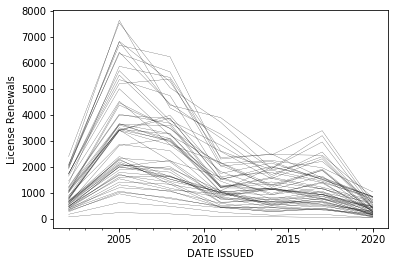

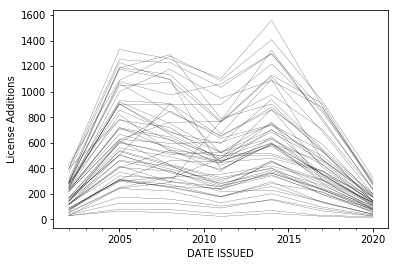

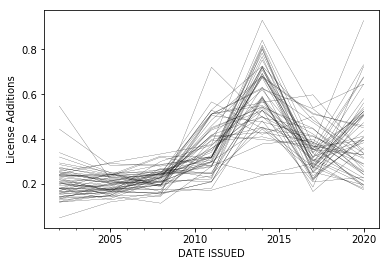

In [1059]:
fig, ax = plt.subplots()
annual_renewals.plot(ax=ax, legend=False, color='k', lw=0.2)
ax.set_ylabel('License Renewals')

fig, ax = plt.subplots()
annual_additions.plot(ax=ax, legend=False, color='k', lw=0.2)
ax.set_ylabel('License Additions')

turnover = annual_additions/annual_renewals

fig, ax = plt.subplots()
turnover.plot(ax=ax, legend=False, color='k', lw=0.2)
ax.set_ylabel('License Additions')


In [1057]:
annual_additions

ZIP CODE,60601,60602,60605,60606,60607,60608,60609,60610,60611,60612,...,60653,60654,60655,60656,60657,60659,60660,60661,60707,60827
DATE ISSUED,,,,,,,,,,,,,,,,,,,,,
2002-12-31,140.0,77.0,120.0,164.0,215.0,427.0,293.0,289.0,243.0,139.0,...,84.0,26.0,35.0,42.0,268.0,229.0,145.0,54.0,53.0,28.0
2003-12-31,180.0,91.0,130.0,167.0,213.0,407.0,334.0,349.0,313.0,210.0,...,108.0,149.0,41.0,62.0,320.0,206.0,158.0,86.0,70.0,22.0
2004-12-31,154.0,116.0,128.0,129.0,224.0,321.0,401.0,467.0,273.0,192.0,...,109.0,47.0,44.0,59.0,293.0,252.0,155.0,81.0,92.0,21.0
2005-12-31,263.0,102.0,146.0,207.0,188.0,360.0,450.0,360.0,414.0,206.0,...,93.0,48.0,42.0,53.0,288.0,207.0,144.0,82.0,79.0,22.0
2006-12-31,215.0,101.0,118.0,171.0,195.0,426.0,560.0,322.0,314.0,185.0,...,103.0,39.0,40.0,82.0,258.0,205.0,137.0,69.0,76.0,22.0
2007-12-31,203.0,115.0,148.0,167.0,315.0,441.0,411.0,400.0,282.0,166.0,...,89.0,41.0,55.0,43.0,298.0,212.0,141.0,133.0,92.0,16.0
2008-12-31,430.0,245.0,275.0,567.0,251.0,412.0,318.0,375.0,579.0,158.0,...,62.0,208.0,32.0,33.0,343.0,149.0,103.0,128.0,55.0,13.0
2009-12-31,206.0,180.0,195.0,203.0,237.0,401.0,298.0,158.0,297.0,155.0,...,71.0,182.0,35.0,48.0,326.0,206.0,98.0,102.0,43.0,9.0
2010-12-31,172.0,143.0,166.0,167.0,261.0,420.0,324.0,127.0,225.0,168.0,...,61.0,275.0,27.0,31.0,303.0,145.0,69.0,126.0,55.0,7.0


In [1044]:
new

#.groupby('DATE ISSUED').count()

,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LICENSE TERM START DATE,LICENSE TERM EXPIRATION DATE,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS,LICENSE STATUS CHANGE DATE,SSA,LATITUDE,LONGITUDE,LOCATION
896088,1195144-20011231,1195144,220691,1,"MOUNTAIN I, INC.",MOUNTAIN I INC,3713 W ROOSEVELT RD,CHICAGO,IL,60624,...,2001-12-31,2002-08-15,2001-12-31,2002-01-02,AAI,NaT,NaN,41.866152,-87.718437,"(41.86615189341997, -87.71843697167586)"
570088,1172019-20020102,1172019,219455,1,ABID SYED QADRI,USA PANTRY,3057 N PULASKI RD,CHICAGO,IL,60641,...,2002-01-02,2002-08-15,2002-01-02,2002-01-02,AAI,NaT,NaN,41.937107,-87.726982,"(41.93710698410429, -87.72698208255794)"
824797,1142031-20011231,1142031,214085,1,NAJI HAJJAR,WALLA SUBMARINE,2856 W ROOSEVELT RD,CHICAGO,IL,60612,...,2001-12-31,2002-11-15,2001-12-31,2002-01-02,AAI,NaT,NaN,41.866592,-87.698196,"(41.866592082671566, -87.69819577390969)"
781028,1144348-20011231,1144348,215398,1,BASHIR AHMED,ORBIT GRILL & SUB,750 S CALIFORNIA AVE,CHICAGO,IL,60612,...,2001-12-31,2002-11-15,2001-12-31,2002-01-02,AAI,NaT,NaN,41.871358,-87.696181,"(41.8713575473368, -87.69618065773754)"
798693,1169252-20011228,1169252,201276,1,ITEHAD INCORPORATED,J&B SUBMAR1NE,6315 S COTTAGE GROVE AVE 1,CHICAGO,IL,60637,...,2001-12-28,2002-08-15,2001-12-28,2002-01-02,AAI,NaT,NaN,41.779927,-87.605773,"(41.779926504277796, -87.60577293833379)"
164240,1194161-20011026,1194161,17965,4,ISIDRO VALDIVIA,valdivia general contracting,5433 W DIVERSEY AVE,CHICAGO,IL,60639,...,2001-10-26,2002-02-15,2001-10-26,2002-01-02,AAI,NaT,NaN,41.931214,-87.762700,"(41.93121385345125, -87.76269964864963)"
894024,1172018-20020102,1172018,219455,1,ABID SYED QADRI,USA PANTRY,3057 N PULASKI RD,CHICAGO,IL,60641,...,2002-01-02,2002-08-15,2001-12-31,2002-01-02,AAI,NaT,NaN,41.937107,-87.726982,"(41.93710698410429, -87.72698208255794)"
428669,1138830-20010504,1138830,54696,3,PROCOM ENTERPRISE LIMITED,PROCOM ENTERPRISES LTD,6615 W IRVING PARK RD 201 #,CHICAGO,IL,60634,...,2001-05-04,2001-11-15,2001-05-04,2002-01-02,AAI,NaT,NaN,41.952708,-87.792109,"(41.95270759569199, -87.79210947400955)"
463117,1139574-20020102,1139574,85325,73,AMERICAN DRUG STORES LLC,OSCO DRUG #0901,3400 N WESTERN AVE,CHICAGO,IL,60618,...,2002-01-02,2002-05-15,2002-01-02,2002-01-02,AAI,NaT,38.0,41.943187,-87.688302,"(41.943187373182425, -87.68830202070191)"
463487,1139572-20020102,1139572,85325,73,AMERICAN DRUG STORES LLC,OSCO DRUG #0901,3400 N WESTERN AVE,CHICAGO,IL,60618,...,2002-01-02,2002-05-15,2002-01-02,2002-01-02,AAI,NaT,38.0,41.943187,-87.688302,"(41.943187373182425, -87.68830202070191)"


In [1040]:
new_2013[new_2013['LICENSE CODE']==1010]['LICENSE DESCRIPTION']

854799    Limited Business License
723390    Limited Business License
717939    Limited Business License
897529    Limited Business License
846463    Limited Business License
776935    Limited Business License
830775    Limited Business License
943185    Limited Business License
388148    Limited Business License
673354    Limited Business License
668830    Limited Business License
893125    Limited Business License
815316    Limited Business License
715230    Limited Business License
874220    Limited Business License
23668     Limited Business License
820892    Limited Business License
691987    Limited Business License
885022    Limited Business License
893177    Limited Business License
874736    Limited Business License
860350    Limited Business License
936022    Limited Business License
675607    Limited Business License
667520    Limited Business License
942485    Limited Business License
672584    Limited Business License
682642    Limited Business License
705449    Limited Bu

In [1038]:
new_2013.groupby('LICENSE CODE').count()

,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LICENSE TERM START DATE,LICENSE TERM EXPIRATION DATE,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS,LICENSE STATUS CHANGE DATE,SSA,LATITUDE,LONGITUDE,LOCATION
LICENSE CODE,,,,,,,,,,,,,,,,,,,,,
1002,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,0,1,9,9,9
1003,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,0,4,35,35,35
1006,1242,1242,1242,1242,1242,1242,1242,1242,1242,1242,...,1241,1242,1242,1242,1242,0,425,1237,1237,1237
1007,34,34,34,34,34,34,34,34,34,34,...,34,34,34,34,34,0,2,34,34,34
1009,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,0,9,43,43,43
1010,2388,2388,2388,2388,2388,2388,2388,2388,2388,2388,...,2388,2388,2387,2388,2388,0,736,2359,2359,2359
1023,108,108,108,108,108,108,108,108,108,108,...,103,108,104,108,108,0,37,107,107,107
1032,42,42,42,42,42,42,42,42,42,42,...,36,42,37,42,42,0,11,42,42,42
1050,37,37,37,37,37,37,37,37,37,37,...,37,37,37,37,37,0,9,36,36,36


In [1036]:
new_2013.columns

Index(['ID', 'LICENSE ID', 'ACCOUNT NUMBER', 'SITE NUMBER', 'LEGAL NAME',
       'DOING BUSINESS AS NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP CODE',
       'WARD', 'PRECINCT', 'WARD PRECINCT', 'POLICE DISTRICT', 'LICENSE CODE',
       'LICENSE DESCRIPTION', 'BUSINESS ACTIVITY ID', 'BUSINESS ACTIVITY',
       'LICENSE NUMBER', 'APPLICATION TYPE', 'APPLICATION CREATED DATE',
       'APPLICATION REQUIREMENTS COMPLETE', 'PAYMENT DATE',
       'CONDITIONAL APPROVAL', 'LICENSE TERM START DATE',
       'LICENSE TERM EXPIRATION DATE', 'LICENSE APPROVED FOR ISSUANCE',
       'DATE ISSUED', 'LICENSE STATUS', 'LICENSE STATUS CHANGE DATE', 'SSA',
       'LATITUDE', 'LONGITUDE', 'LOCATION'],
      dtype='object')

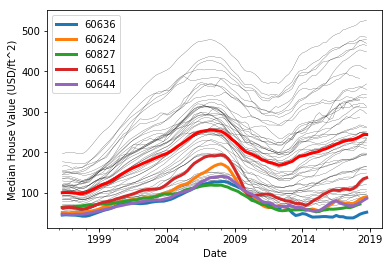

In [86]:
fig, ax = plt.subplots()
price_matrix.plot(ax=ax, legend=False, color='k', lw=0.2)
ax.set_ylabel('Median House Value (USD/ft^2)')

trend = price_matrix.mean(axis=1)
trend.plot(ax=ax, color='r', lw=3)

price_matrix.loc[:, ptp.sort_values(ascending=False).iloc[:N].index].plot(ax=ax, lw=3)

In [81]:
av_window = 3
normalized_price_matrix = np.log2(price_matrix / price_matrix.iloc[:4*av_window].mean(axis=0))
normalized_price_matrix = normalized_price_matrix.iloc[4*av_window:, :]

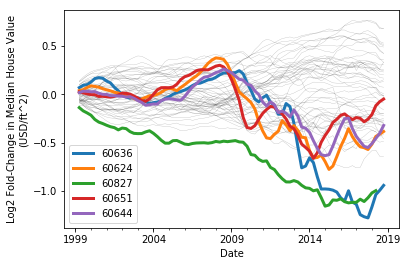

In [84]:
trend = normalized_price_matrix.mean(axis=1)
trend.plot(ax=ax, color='k', lw=10)

detrended = normalized_price_matrix.subtract(trend, axis=0)
fig, ax = plt.subplots()
detrended.plot(ax=ax, legend=False, color='k', alpha=0.3, lw=0.3)
ax.set_ylabel('Log2 Fold-Change in Median House Value\n(USD/ft^2)')

# highlight top five most dramatic changes
N = 5
ptp = detrended.max(axis=0) - detrended.min(axis=0)
detrended.loc[:, ptp.sort_values(ascending=False).iloc[:N].index].plot(ax=ax, lw=3)

In [77]:
from scipy.signal import savgol_filter

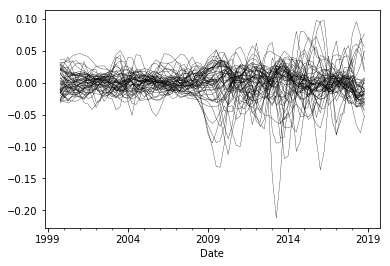

In [85]:
fig, ax = plt.subplots()

horizon = 3
derivative = detrended.diff(axis=0, periods=1).apply(savgol_filter, axis=0, args=(horizon, 1))
derivative.plot(ax=ax, legend=False, color='k', lw=0.3)

In [586]:
# exclude zipcodes with low activity from all data
min_renewals = 10
zipcodes_with_low_activity = renewals.columns[renewals.mean(axis=0) < min_renewals].values

In [ ]:
# align data then simple model - do derivatives correlate with housing market?

In [ ]:
"""
Hypotheses:

- Retention rate of business licenses as an indicator? E.g. business turnover is bad
- Introduction of new businesses as an indicator
- Type of new businesses being introduced
- Licenses for entertainment, street festivals, alcohol, etc 
- Spatiotemporal clustering with adjacent zipcodes

"""